In [ ]:
# !pip install --user numpy==1.26.2
# !pip install --user matplotlib==3.6.2
# !pip install emoji==2.10.0
# !pip install python-dotenv==1.0.1
# !pip install selenium==4.17.2
# !pip install sentencepiece==0.1.99
# !pip install --user datasets==2.17.0
# !pip install --user transformers==4.36.0
# !pip install evaluate==0.4.1
# !pip install sacrebleu==2.4.0
# !pip install --user torch==1.13.0+cu117
# !pip install accelerate==0.27.2
# !pip install text_unidecode==1.3
# !pip install nltk==3.8.1
# !pip install typing_extensions==4.9.0
# !pip install --user spacy==3.5.0
# !pip install navec==0.10.0
# !pip install tqdm==4.66.1
# !pip install pyTelegramBotAPI==4.16.0
# !pip install telebot==0.0.5
# !pip install pandas==2.1.1

In [20]:
from selenium import webdriver # для браузера
from selenium.webdriver.chrome.service import Service # сервис для запуска Chrome 
from selenium.webdriver.common.keys import Keys # для отправки запросов
from selenium.webdriver.common.by import By # для поиска на странице
import time # для работы с временем

import re # регулярные выражения для работы с текстом
import json # для сохранения файлов
import sys # для работы с переменными окружения
import numpy as np # для работы с массивами
import pandas as pd # для отображения таблиц

import torch # для работы с моделями
import evaluate # для метрик
import matplotlib.pyplot as plt # для построения графиков
from tqdm import tqdm # для отслеживания прогресса
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict # для работы с датасетом
from transformers import AutoTokenizer, T5ForConditionalGeneration, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer # для работы с моделью (токенизация, обучение...)
from huggingface_hub import notebook_login # для отправки модели и датасета на hugging face

import emoji # для работы с эмодзи
import spacy # для обработки текста (токенизация, лемматизация, тегирование части речи)
from nltk.corpus import stopwords # стоп-слова
from navec import Navec # для векторизации текста
from models.convertation.torchmoji.sentence_tokenizer import SentenceTokenizer # токенизатор для torchMoji
from models.convertation.torchmoji.model_def import torchmoji_emojis # модель torchMoji

# Шаг 1: сбор датасета для проекта

Web драйвер для браузера был скачен с сайта https://googlechromelabs.github.io/chrome-for-testing/ (версия 121.0.6167.161)

In [6]:
executable_path = './chromedriver.exe' # путь до запускаемого драйвера
service = Service(executable_path=executable_path) # настройки для запуска браузера
pages = 5 # число страниц для рассмотрения

In [ ]:
movies = [] # список под фильмы в формате, далее будет более подробно расписано его содержание
# [{
#   "title": название фильма, 
#   "description": описание, 
#   "emojis": транскрипция в эмодзи,
#   "categories": категории, 
#   "year": год выхода,
#   "directors": режиссёры, 
#   "actors": известные актёры, 
#   "tagline": слоган,
#   "hint": подсказка про наличие цифр в названии,
#   "movie_url": ссылка на страницу фильма
#  }, ...
# ]

Сначала соберём основную информацию о мультфильме (название + ссылка + подсказки для названия).

In [ ]:
driver = webdriver.Chrome(service=service) # запуск браузера
driver.get("https://www.kinopoisk.ru/") # открытие страницы (GET запрос)
time.sleep(15) # время для введения капчи

for page in range(1, pages+1): # идём по числу страниц
    url = f"http://www.kinopoisk.ru/lists/movies/genre--animation/?b=films&sort=votes&page={page}" # ссылка с указанием страницы
    driver.get(url) # открытие страницы (GET запрос)

    # for movie in driver.find_elements("class name", "styles_root__ti07r"): # находим все элементы, отвечающие за мультфильмы на сайте и проходим по им всем
    for movie in driver.find_elements(By.CLASS_NAME, "styles_root__ti07r"): # находим все элементы, отвечающие за мультфильмы на сайте и проходим по им всем
        try: # так как может попасться рекламный блок
            title = movie.find_elements(By.TAG_NAME, "span")[0].text # находим название фильма (первый span элемент)
        except:
            continue # переходим к следующему элементу

        hint = [] # подсказка про наличие чисел в названии
        for word in re.sub('[^\w\s]', '', title).split(): # идём по "словам" в названии, в котором удалено всё, что не(^) буква/цифра/_(\w) и не пробельный символ(\s)
            if word.isdigit(): # если попали на число в названии
                hint.append(word) # добавляем "слово" (число) в список для подсказок
        
        movie_url = movie.find_element(By.TAG_NAME, "a").get_attribute("href") # получение ссылки на фильм (например: 'https://www.kinopoisk.ru/film/775276/')
        
        movies.append({"title": title, "description": None, "emojis": None, "categories": None, "year": None, "directors": None, "actors": None, "tagline": None, "hint": hint, "movie_url": movie_url}) # добавляем фильм в список с фильмами в виде словаря
driver.quit() # закрытие браузера

In [ ]:
movies[15] # пример содержимого списка фильмов после первого прохода

{'title': 'Шрэк 2',
 'description': None,
 'emojis': None,
 'categories': None,
 'year': None,
 'directors': None,
 'actors': None,
 'tagline': None,
 'hint': ['2'],
 'movie_url': 'https://www.kinopoisk.ru/film/5273/'}

Затем пройдём по полученным на первом шаге ссылкам и возьмём подробную информацию о мультфильмах.

In [ ]:
driver = webdriver.Chrome(service=service) # запуск браузера

driver.get("https://www.kinopoisk.ru/") # открытие страницы (GET запрос)
time.sleep(15) # время для введения капчи

for movie in movies: # идём по списку фильмов
    driver.get(movie["movie_url"]) # открытие страницы фильма (GET запрос)

    movie["year"] = driver.find_element(By.XPATH, "//*[contains(text(), 'Год производства')]").find_element(By.XPATH, "following-sibling::*").text # получаем год

    movie["tagline"] = driver.find_element(By.XPATH, "//*[contains(text(), 'Слоган')]").find_element(By.XPATH, "following-sibling::*").text # получаем слоган

    movie["description"] = "" # синопсис
    for p in driver.find_elements(By.CLASS_NAME, "styles_paragraph__wEGPz"): # находим блоки с текстом <p>...</p>
        movie["description"] += p.text + " " # добавляем их содержимое в синопсис
    for p in driver.find_elements(By.CLASS_NAME, "styles_root__aZJRN"): # находим блоки с текстом <p>...</p>
        movie["description"] += p.text # добавляем их содержимое в синопсис

    movie["categories"] = [] # категории
    for category in driver.find_element(By.XPATH, "//*[contains(text(), 'Жанр')]").find_element(By.XPATH, "following-sibling::*").find_element(By.XPATH, "*[1]").find_elements(By.TAG_NAME, "a"): # находим все элементы, соответствующие категориям (оформлены в виде ссылок)
        movie["categories"].append(category.text) # добавляем категорию
    
    movie["directors"] = [] # режиссёр
    for director in driver.find_element(By.XPATH, "//*[contains(text(), 'Режиссер')]").find_element(By.XPATH, "following-sibling::*").find_elements(By.TAG_NAME, "a"): # находим все элементы, соответствующие режиссёрам (оформлены в виде ссылок)
        movie["directors"].append(director.text) # добавляем режиссёра

    movie["actors"] = [] # известные актёры
    try: # в некоторых мультфильмов нет списка актёров...
        for actor in driver.find_elements(By.CLASS_NAME, "styles_list___ufg4")[0].find_elements(By.TAG_NAME, "li"): # находим первый (0) список ul, он содержит известных актёров и берём из него все элементы
            movie["actors"].append(actor.text) # добавляем текст поля li (актёра) в список
    except: # пусть так и останется
        pass

driver.quit() # закрытие браузера

In [12]:
movies[15] # пример содержимого списка мультфильмов после второго прохода

{'title': 'Шрэк 2',
 'description': 'Шрэк и Фиона возвращаются после медового месяца и находят письмо от родителей Фионы с приглашением на ужин. Однако те не подозревают, что их дочь тоже стала огром! Вместе с Осликом счастливая пара отправляется в путешествие, полное неожиданностей, и попадает в круговорот событий, во время которых приобретает множество друзей… ',
 'emojis': None,
 'categories': ['мультфильм',
  'фэнтези',
  'мелодрама',
  'комедия',
  'приключения',
  'семейный'],
 'year': '2004',
 'directors': ['Эндрю Адамсон', 'Келли Эсбёри', 'Конрад Вернон'],
 'actors': ['Майк Майерс',
  'Эдди Мерфи',
  'Кэмерон Диас',
  'Джули Эндрюс',
  'Антонио Бандерас',
  'Джон Клиз',
  'Руперт Эверетт',
  'Дженнифер Сондерс',
  'Арон Уорнер',
  'Келли Эсбёри'],
 'tagline': '«Not so far, far away...»',
 'hint': ['2'],
 'movie_url': 'https://www.kinopoisk.ru/film/5273/'}

In [13]:
with open('./data/movies_base.json', 'w') as f: # открытие файла для записи ('w')
    json.dump(movies, f) # сохраняем в него данные о фильмах

# Шаг 2: модель для суммаризации текста

<b>
Цель: найти модель, что наилучшим образом (быстро и качественно) проводит суммаризацию (и упрощение) синопсиса фильма и провести её fine-tuning. 
</b>

## В качестве используемой модели  был выбран [T5](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta), обученный на датасете [Gazeta](https://huggingface.co/datasets/IlyaGusev/gazeta)

T5 был выбран в связи с тем, что он показывает результаты, сравнимые с лучшими моделями для русскоязычнох текстов, но при этом имеет гораздо меньше параметров (из-за чего умешается на GPU) и хорошую скорость на инференсе!

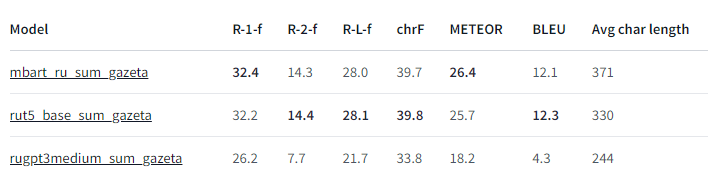

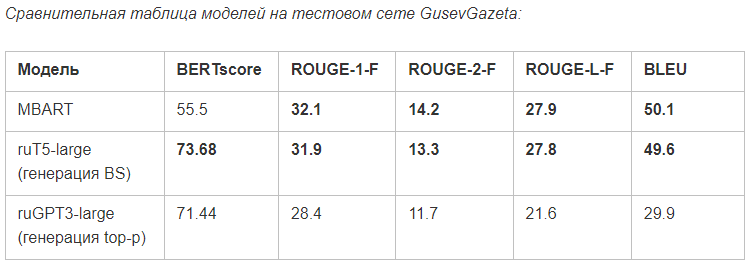

BLEU (BiLingual Evaluation Understudy) — метрика, разработанная в IBM (Papineni et al.) в 2001. Основана на подсчете слов (unigrams) и словосочетаний (n‑grams) из машинного перевода, также встречающихся в эталоне. Далее это число делится на общее число слов и словосочетаний в машинном переводе — получается precision. К итоговому precision применяется корректировка — штраф за краткость (brevity penalty), чтобы избежать слишком высоких оценок BLEU для кратких и неполных переводов.

METEOR (Metric for Evaluation of Translation with Explicit ORdering) – метрика качества машинного перевода, предложенная Banerjee and Lavie в 2005.

Оценка основана на подсчете совпадений отдельных слов (unigrams), c расчетом precision, recall, а также обобщающего показателя гармонического среднего (Fmean). В качестве совпадений учитываются не только точные соответствия слов (как в BLEU или ROUGE), но и наличие однокоренных слов или синонимов.

Итоговая метрика METEOR рассчитывается путем применения к Fmean штрафа за малую длину либо отсутствие совпадающих n-grams.

* Берём модель с Hugging Face:

In [33]:
model_name = "IlyaGusev/rut5_base_sum_gazeta" # название модели на huggingface
model = T5ForConditionalGeneration.from_pretrained(model_name) # загружаем предобученную модель
tokenizer = AutoTokenizer.from_pretrained(model_name) # загружаем токенайзер

* Сохраняем одним из вариантов

In [97]:
# torch.save(model.config, "./models/summarization/t5/config.pth") # сохраняем config модели
# torch.save(model.state_dict(), "./models/summarization/t5/state_dict.pth") # сохраняем state_dict модели

model.save_pretrained("./models/summarization/t5/")

In [ ]:
tokenizer.save_pretrained("./models/summarization/t5/") # сохраняем токенайзер

* Или берём локальное сохранение:

In [26]:
# model = AutoModelForSeq2SeqLM.from_config(torch.load("./models/summarization/t5/config.pth"))
# model = T5ForConditionalGeneration(torch.load("./models/summarization/t5/config.pth")) # создаём модель с сохранённой конфигурацией

# model.load_state_dict(torch.load("./models/summarization/t5/state_dict.pth")) # загружаем предобученную модель

model = AutoModelForSeq2SeqLM.from_pretrained("./models/summarization/t5/")

model.eval() # переводим модель в режим оценивания

In [20]:
tokenizer = AutoTokenizer.from_pretrained("./models/summarization/t5/") # загружаем предобученный токенайзер
tokenizer

T5TokenizerFast(name_or_path='./models/summarization/t5/', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Пример суммаризации текста моделью:

In [29]:
text = "Зима в этом году в тридевятом царстве случилась особенно долгая и холодная. Прямо, как в прошлом году. И как в позапрошлом. Но, вот, пришла весна. Точнее – почти пришла. С вьюгой, морозами и снегом. Как обычно. И совсем было загрустили наши герои – Иван, Василиса, Серый Волк и Царь-батюшка, если бы вместе с почти-весной, не пришла новость - в Трисемнадцатом царстве пройдет ежегодный всесказочный конкурс песни. В прошлом году там победил хомяк Жорж, а чей голос окажется круче на этот раз? Царь решил, что Тридевятое царство будет представлять Кот-ученый. Не один все же мультфильм прошли вместе, да и все равно он про книги забыл, орет, точнее поет целыми днями на крышах, как и положено коту в марте. И, конечно, вся компания во главе с Иваном и Волком отправляется поддержать пушистого певца. Ведь свои нужны рядом. А то шоу-бизнес – настоящий серпентарий, и кто знает, какие темные силы стоят за коварными соперниками и их стремлением стать звездой. Кот ученый и друзья едут за тридевять земель на конкурс песни. Музыкальная сказка о волшебном мире шоу-бизнеса."

In [30]:
def summarize(text, model, tokenizer): # функция для суммаризации текста
    input_ids = tokenizer( # токенизируем текст
        [text], # текст, что будет токенизирован
        max_length=600, # максимальное число токенов
        add_special_tokens=True, # добавлять или нет специальные токены при кодировании последовательности (строки)
        padding="max_length", # добавление токенов паддинга до достижения максимальной длины
        truncation=True, # усечение числа токенов, если их больше max_length
        return_tensors="pt", # тип возвращаемого тензора (pytorch)
    )["input_ids"] # берём данные "input_ids" (сами токены)

    output_ids = model.generate( # генерируем суммаризацию
        input_ids=input_ids, # передаём входные токены
        no_repeat_ngram_size=4 # n-grams данного размера могут возникнуть лишь раз
    )[0] # [0] — берём вложение

    summary = tokenizer.decode(output_ids, skip_special_tokens=True) # декодируем получившиеся токены в слова (строку) с пропуском специальных токенов (skip_special_tokens=True)
    return summary # вывод получившегося саммари

In [203]:
summarize(text, model, tokenizer) # результат суммаризации

В Тридевятое царство пройдет ежегодный всесказочный конкурс песни. Вместе с Котом ученым и друзьями пройдет мультфильм о волшебном мире шоу-бизнеса.


Суммаризация получилась относительно качественной, однако из-за специфики датасета, на котором предобучалась модель, результат на некоторых сэмплах склонен "видоизменяться" под газетные статьи.

In [ ]:
with open('./data/movies_base.json', 'r') as f: # открываем файл для чтения ('r')
    movies = json.load(f) # загружаем данные

In [4]:
for movie in tqdm(movies): # идём по мультфильмам
    movie["description"] = summarize(movie["description"], model, tokenizer) # проводим суммаризацию текста

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [1:08:39<00:00, 16.48s/it]


In [6]:
with open('./data/movies_t5.json', 'w') as f: # открытие файла для записи ('w')
    json.dump(movies, f) # сохраняем в него данные о фильмах

## Обучающий датасет

Дообучим модель на другом датасете — [MultiSim](https://huggingface.co/datasets/MichaelR207/MultiSim) и сравним качество получившейся суммаризации.

Данный датасет включает множество языков, помимо русского. Содержит train/test/validation splits, однако на русском языке лучше всего составлена только часть train, поэтому она будет разделена на train и test.

In [47]:
dataset = load_dataset("MichaelR207/MultiSim") # загружаем датасет с huggingface
dataset = dataset.shuffle() # перемешиваем датасет

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\datasets\load.py:1454: FutureWarning: The repository for MichaelR207/MultiSim contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/MichaelR207/MultiSim
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Найдём записи на русском языке и немного очистим их от лишних/неверных символов.

In [74]:
ru_index_train = [] # список под сэплы в датасете, содержащие русский язык
for i, sample in enumerate(dataset["train"]): # идём по сэмплам
    if re.search('[а-яА-Я]', sample["original"]): # если нашли хоть одну русскую букву
        sample["original"] = re.sub("\x06", " ", sample["original"]).strip() # заменяем символ "\x06" на пробел и удаляем лишние пробелы
        sample["simple"]["simplifications"][0] = re.sub("\x06", " ", sample["simple"]["simplifications"][0]).strip() # заменяем символ "\x06" на пробел и удаляем лишние пробелы
        ru_index_train.append(i) # запоминаем номер сэмпла

In [75]:
split_index = int(len(ru_index_train) * 0.8) # индекс для сплита 80%/20%
train_elements = ru_index_train[:split_index] # номера сэмплов, что пойдут в обучающую выборку
test_elements = ru_index_train[split_index:] # номера сэмплов, что пойдут в оценочную выборку

In [76]:
train_dataset = Dataset.from_dict({ # собираем датасет для обучения
    "original" : dataset["train"][train_elements]["original"], # берём оригинальные элементы, соответствующие train_elements
    "simple" : [sample["simplifications"][0] for sample in dataset["train"][train_elements]["simple"]] # берём суммаризацию (вложенная), соответствующие train_elements
    })

test_dataset = Dataset.from_dict({ # собираем датасет для оценивания
    "original" : dataset["train"][test_elements]["original"], # берём оригинальные элементы, соответствующие test_elements
    "simple" : [sample["simplifications"][0] for sample in dataset["train"][test_elements]["simple"]] # берём суммаризацию (вложенная), соответствующие test_elements
    })

dataset = DatasetDict({"train": train_dataset, "test": test_dataset}) # собираем обратно DatasetDict

In [79]:
dataset.save_to_disk("./data/MultiSim_ru") # сохраняем собранный датасет с помощью Arrow

Saving the dataset (0/1 shards):   0%|          | 0/206695 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/51674 [00:00<?, ? examples/s]

## Fine-tuning

In [2]:
dataset = load_from_disk("./data/MultiSim_ru") # загружаем сохранённый датасет

In [3]:
data_train = Dataset.from_dict(dataset["train"][:10000]) # берём определённую часть датасета для обучения (так как весь датасет слишком большой)
data_test = Dataset.from_dict(dataset["test"][:1000]) # берём определённую часть датасета для оценки (так как весь датасет слишком большой)
dataset = DatasetDict({"train": data_train, "test": data_test}) # собираем датасеты обратно

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained("./models/summarization/t5/") # загружаем сохранённую модель
model.train() # переводим модель в режим обучения

T5ForConditionalGeneration(
  (shared): Embedding(30000, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(30000, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [5]:
tokenizer = AutoTokenizer.from_pretrained("./models/summarization/t5/", do_lower_case=False, strip_accents=False) # загружаем предобученный токенайзер (do_lower_case=False — без приведения к нижнему регистру)
tokenizer # особенности токенайзера (tokenizer.vocab для просмотра данных слово—токен)

T5TokenizerFast(name_or_path='./models/summarization/t5/', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
def preprocess_function(dataset): # функция для токенизации текста
    # токенизация данных (в датасете появятся солбцы "input_ids" с токенами входа, "attention_mask" и "labels" с ожидаемыми токенами предсказания)
    model_inputs = tokenizer(dataset["original"], text_target=dataset["simple"], max_length=600, padding=False, truncation=True) # токенизируем данные (без паддинга, но с обрезанием лишних токенов)
    return model_inputs

In [7]:
tokenized_dataset = dataset.map(preprocess_function, batched=True) # применяем функцию preprocess_function ко всем данным в датасете

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
tokenized_dataset["train"][0] # пример текущего содержимого датасета

{'original': 'Луаре - это департамент на севере центральной части Франции, названный в честь реки Луаре.',
 'simple': 'Луаре - это департамент, расположенный в центре Франции в Центральном регионе.',
 'input_ids': [4661,
  21275,
  259,
  264,
  1205,
  259,
  15024,
  310,
  15095,
  324,
  3734,
  6776,
  4286,
  18083,
  279,
  261,
  21146,
  1292,
  315,
  6229,
  833,
  259,
  25263,
  4661,
  21275,
  260,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [4661,
  21275,
  259,
  264,
  1205,
  259,
  15024,
  261,
  259,
  10913,
  1292,
  315,
  3734,
  324,
  18083,
  279,
  315,
  259,
  26328,
  637,
  6062,
  324,
  260,
  1]}

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model) # создаём компановщик данных для передачи их во время обучения

In [10]:
metric = evaluate.load("sacrebleu") # загружаем метрику для задачи

# metric.compute(predictions=["this is a dog"], references=[["is a dog"]])
# predictions — list из предсказаний (str)
# references — list из list (из ожидаемых ответов (str)) для каждого элемента в predictions
# {'score': 59.460355750136046,
#  'counts': [3, 2, 1, 0],
#  'totals': [4, 3, 2, 1],
#  'precisions': [75.0, 66.66666666666667, 50.0, 50.0],
#  'bp': 1.0,
#  'sys_len': 4,
#  'ref_len': 3}

In [11]:
def compute_metrics(eval_preds): # функция для подсчёта метрики
    preds, labels = eval_preds # разделяем предсказания 
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) # декодируем токены предсказаний в слова (предложения)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) # декодируем токены ожидания в слова (предложения)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels) # считаем значение метрики
    result = {"bleu": result["score"]} # добавляем в список метрик

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds] # считаем число токенов в предсказании
    result["gen_len"] = np.mean(prediction_lens) # считаем среднюю длину предсказания
    result = {k: round(v, 4) for k, v in result.items()} # округляем числа до 4 знаков после запятой
    return result

In [12]:
training_args = Seq2SeqTrainingArguments( # аргументы для обучения
    # output_dir="C:/Users/User/Desktop/t5/training", # путь, по которому будут сохраняться чекпоинты (и предсказания) во время обучения (ПОЛНЫЙ путь не должен включать кириллицу)
    output_dir="./models/summarization/t5/training", # путь, по которому будут сохраняться чекпоинты (и предсказания) во время обучения (ПОЛНЫЙ путь не должен включать кириллицу)
    overwrite_output_dir=False, # перезаписывать ли содержимое папки OUTPUT_DIR, если имена будут совпадать
    save_total_limit=None, # сколько максимум хранить чекпоинтов в папке, старые будут просто перезаписываться (None — без лимита)
    num_train_epochs=5, # число эпох для обучения
    learning_rate=0.0005, # размер шага обучения
    gradient_accumulation_steps=1, # число итераций, за которые будет накапливаться градиент для backward pass (обновления параметров модели)
    per_device_train_batch_size=8, # размер батча при обучении (число сэмлов, передающееся в модель за одну итерацию)
    per_device_eval_batch_size=8, # размер батча при оценивании (число сэмлов, передающееся в модель за одну итерацию)
    evaluation_strategy="steps", # как часто оценивать качество обучения (возможные значения: "no", "steps", "epoch")
    eval_steps=200, # через сколько шагов обновления проводить оценку качества (только при использовании EVAL_STRATEGY="steps")
    save_strategy="steps", # как часто сохранять чекпоинты обучения (возможные значения: "no", "steps", "epoch")
    save_steps=200, # через сколько шагов обновления сохранять чекпоинт (только при использовании SAVE_STRATEGY="steps")
    logging_strategy="steps", # как часто выводить лог обучения (возможные значения: "no", "steps", "epoch")
    logging_steps=200, # через сколько шагов обновления выводить лог (только при использовании EVAL_STRATEGY="steps")
    warmup_steps=100, # количество шагов, используемое для линейного увеличения learning_rate от 0 до LEARNING_RATE
    fp16=False, # работать ли с fp16 вместо fp32
    predict_with_generate=True, # использовать ли метод generate для подсчёта генеративных метрик (ROUGE, BLEU)
    load_best_model_at_end=True, # возвращать ли лучшую модель в конце обучения
    metric_for_best_model="bleu", # название метрики, по которой будет определяться лучшая модель
    greater_is_better=True # для LOAD_BEST_MODEL_AT_END и METRIC_FOR_BEST_MODEL, чтобы определить, должна ли метрика увеличиваться
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model, # обучаемая модель
    args=training_args, # аргументы для обучения
    train_dataset=tokenized_dataset["train"], # датасет для обучения
    eval_dataset=tokenized_dataset["test"], # датасет для оценки
    tokenizer=tokenizer, # токенизатор
    data_collator=data_collator, # компоновщик данных для подгрузки при обучении
    compute_metrics=compute_metrics, # функция для подсчёта метрик
)

trainer.train() # запуск обучения

In [14]:
trainer.evaluate(tokenized_dataset["test"]) # повтор оценки качества финальной модели

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.6676487922668457,
 'eval_bleu': 36.2238,
 'eval_gen_len': 41.666,
 'eval_runtime': 843.396,
 'eval_samples_per_second': 1.186,
 'eval_steps_per_second': 0.148,
 'epoch': 5.0}

In [15]:
model.to("cpu") # возвращаем модель на cpu, если она была на cuda во время обучения
model.save_pretrained("./models/summarization/t5_finetuned/") # сохраняем модель после обучения
# model == trainer.model
tokenizer.save_pretrained("./models/summarization/t5_finetuned/") # сохраняем токенайзер

('./models/summarization/t5_finetuned/tokenizer_config.json',
 './models/summarization/t5_finetuned/special_tokens_map.json',
 './models/summarization/t5_finetuned/spiece.model',
 './models/summarization/t5_finetuned/added_tokens.json',
 './models/summarization/t5_finetuned/tokenizer.json')

In [27]:
with open("./models/summarization/t5_finetuned/log_history.json", 'w') as f: # открытие файла для записи ('w')
    json.dump(trainer.state.log_history, f) # сохраняем в него историю обучения

Проверим качество дообученной модели.

In [4]:
train_loss = []
train_epoch = []
eval_bleu = []
eval_epoch = []

for step in trainer.state.log_history:
    if "loss" in step.keys():
        train_loss.append(step["loss"])
        train_epoch.append(step["epoch"])
    if "eval_bleu" in step.keys():
        eval_bleu.append(step["eval_bleu"])
        eval_epoch.append(step["epoch"])

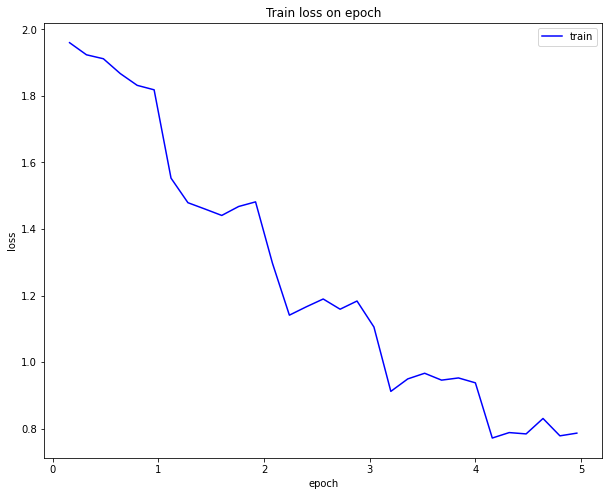

In [16]:
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(train_epoch, train_loss, color="b", label='train') # построение CrossEntropyLoss на обучении
plt.title('Train loss on epoch') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('loss') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

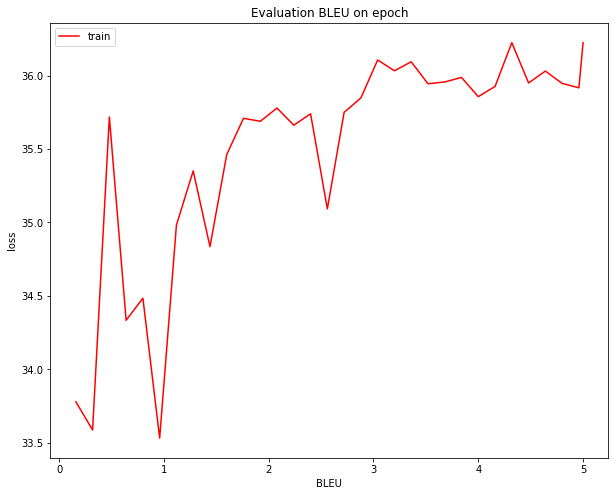

In [19]:
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(eval_epoch, eval_bleu, color="r", label='train') # построение CrossEntropyLoss на обучении
plt.title('Evaluation BLEU on epoch') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('BLEU') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

In [28]:
summarize(text, model, tokenizer) # результат суммаризации

'Зима в этом году в тридевятом царстве случилась особенно холодная. В прошлом году там победил хомяк Жорж, а чей голос окажется круче на этот раз?'

**Результатом обучения стало:**
1) модель перестала работать в контексте газетных статей (был проведён domain shift)
2) слегка увеличилась метрика BLEU, отражающая качество совпадения предсказания (суммаризации) с ожиданием

### Сохраним модель и датасет на Hugging face:

In [13]:
notebook_login() # подключаемся к Hugging Face по токену 'write'

In [8]:
model.push_to_hub("t5_ru_finetuned") # сохраняем модель на Hugging Face

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/KabanovDenis/t5_ru_finetuned/commit/fb3c3f0fec9928d63ed9931fafc13efa9f9b77b6', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='fb3c3f0fec9928d63ed9931fafc13efa9f9b77b6', pr_url=None, pr_revision=None, pr_num=None)

In [9]:
tokenizer.push_to_hub("t5_ru_finetuned") # сохраняем токенайзер на Hugging Face

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/KabanovDenis/t5_ru_finetuned/commit/b10b24fdd3b6bc4dc8e4b25b239af7aaf0764710', commit_message='Upload tokenizer', commit_description='', oid='b10b24fdd3b6bc4dc8e4b25b239af7aaf0764710', pr_url=None, pr_revision=None, pr_num=None)

In [12]:
dataset.push_to_hub("MultiSim_ru") # сохраняем датасет на Hugging Face

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/207 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/52 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/KabanovDenis/MultiSim_ru/commit/a7ef4890e4ccc88df21409fc6c2ecd0ee7ed2bd6', commit_message='Upload dataset', commit_description='', oid='a7ef4890e4ccc88df21409fc6c2ecd0ee7ed2bd6', pr_url=None, pr_revision=None, pr_num=None)

# Шаг 3: конвертация текста в эмодзи

<b>
Цель: рассмотреть варианты конвертации полученного саммари в последовательность эмодзи. 
</b>

## Вариант 1: простое ручное конвертирование текста в эмодзи

Библиотеки, поддерживающие работу с эмодзи: emoji, emojis, emoji-translate, vader-sentiment... Однако только emoji имеет среди распознаваемых языков — русский.

In [30]:
text = "Самолёт пролетел над городом N и приземлился..."
text = text.lower()
text = text.replace("ё", "е")
text = re.sub('[^\w\s]', ' ', text).split()
text = ":" + ": :".join(text) + ":"

text = emoji.emojize(text, language="ru", )
text = text.replace(":", "")
text

'✈️ пролетел над городом n и приземлился'

#### Вывод: такая конвертация малопригодна для задачи, так как только малое число слов идеально совпадает с названиями эмодзи.

## Вариант 2: использование специально обученной модели

Среди таких моделей можно рассмотреть torchMoji (deepMoji) и Text_to_Emoji (https://github.com/niladridutt/Text_to_Emoji?tab=readme-ov-file), обе работают только с английским языком.

In [14]:
ROOT_PATH = "./models/convertation/" # корневой путь
VOCAB_PATH = f'{ROOT_PATH}/torchmoji/vocabulary.json' # руть до словаря, нужен для токенизации
PRETRAINED_PATH = f'{ROOT_PATH}/torchmoji/torchMoji.bin' # путь до обученной модели

EMOJIS = ":joy: :unamused: :weary: :sob: :heart_eyes: \
:pensive: :ok_hand: :blush: :heart: :smirk: \
:grin: :notes: :flushed: :100: :sleeping: \
:relieved: :relaxed: :raised_hands: :two_hearts: :expressionless: \
:sweat_smile: :pray: :confused: :kissing_heart: :heartbeat: \
:neutral_face: :information_desk_person: :disappointed: :see_no_evil: :tired_face: \
:v: :sunglasses: :rage: :thumbsup: :cry: \
:sleepy: :yum: :triumph: :hand: :mask: \
:clap: :eyes: :gun: :persevere: :smiling_imp: \
:sweat: :broken_heart: :yellow_heart: :musical_note: :speak_no_evil: \
:wink: :skull: :confounded: :smile: :stuck_out_tongue_winking_eye: \
:angry: :no_good: :muscle: :facepunch: :purple_heart: \
:sparkling_heart: :blue_heart: :grimacing: :sparkles:".split(' ') # эмодзи, поддерживаемые моделью

In [15]:
sys.path.append(ROOT_PATH) # добавляем путь до моделей в PATH

In [50]:
model_torchmoji = torchmoji_emojis(PRETRAINED_PATH) # загрузка предобученной модели
model_torchmoji # вывод строения модели

TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0, inplace=False)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0, inplace=False)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax(dim=None)
  )
)

In [19]:
with open(VOCAB_PATH, 'r') as f: # открываем файл со словарём модели
    vocabulary = json.load(f) # загружаем словарь
list(vocabulary.items())[:20] # первые 20 элементов словаря (токенов)

[('CUSTOM_MASK', 0),
 ('CUSTOM_UNKNOWN', 1),
 ('CUSTOM_AT', 2),
 ('CUSTOM_URL', 3),
 ('CUSTOM_NUMBER', 4),
 ('CUSTOM_BREAK', 5),
 ('CUSTOM_BLANK_6', 6),
 ('CUSTOM_BLANK_7', 7),
 ('CUSTOM_BLANK_8', 8),
 ('CUSTOM_BLANK_9', 9),
 ('the', 10),
 ('.', 11),
 ('and', 12),
 ('you', 13),
 (',', 14),
 ('a', 15),
 ('for', 16),
 ('to', 17),
 ('i', 18),
 ('!', 19)]

In [54]:
text = "A tale set on death row in a Southern jail, where gentle giant John Coffee (Michael Clarke Duncan) possesses the mysterious power to heal people's ailments. When the lead guard, Paul Edgecombe (Tom Hanks), recognizes John's gift, he tries to help stave off the condemned man's execution." # текстовый пример

sentence_tokenizer = SentenceTokenizer(vocabulary, 100) # объект токенайзера, требует указания словаря и числа токенов

tokenized, _, _ = sentence_tokenizer.tokenize_sentences([text, ]) # токенизируем текст
tokenized # пример полученных токенов

array([[   15,  2115,   389,    44,   748,  2323,    36,    15,  3393,
         2371,    14,   176,  6582,  2169,   858,   511,    99,  1532,
        17189,  9542,    97,     1,    10,  7841,   526,    17,  6774,
         2405,     1,    11,    63,    10,  1802,  3467,    14,  1209,
            1,    99,  1820, 19736,    97,    14, 13727, 12895,   580,
           14,   189,  2585,    17,   340,     1,   109,    10, 43549,
         3744,  3941,    11,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=uint16)

In [29]:
prob = model_torchmoji(tokenized)[0] # получаем вероятности эмодзи (модель поддерживает 64 эмодзи)
prob

array([0.00826604, 0.00794725, 0.00388433, 0.00444268, 0.00250981,
       0.01025149, 0.00719884, 0.0085858 , 0.01724289, 0.00555669,
       0.00797884, 0.02316808, 0.02480408, 0.00709422, 0.00218912,
       0.00350395, 0.00767403, 0.01006989, 0.00342063, 0.02203122,
       0.01141116, 0.02512378, 0.03316531, 0.00193796, 0.02461221,
       0.032507  , 0.00186689, 0.02046843, 0.00663869, 0.00528804,
       0.01512323, 0.0126198 , 0.0813021 , 0.02874656, 0.03152588,
       0.00842565, 0.00332252, 0.02005173, 0.00240824, 0.00955561,
       0.01205385, 0.01638797, 0.01766201, 0.02012684, 0.03690895,
       0.01790947, 0.02698752, 0.01898514, 0.00781498, 0.00443472,
       0.02008365, 0.02816985, 0.02341518, 0.01876715, 0.02068366,
       0.05879206, 0.00465287, 0.01031846, 0.01625735, 0.00929255,
       0.00573174, 0.01060102, 0.02345336, 0.00658895], dtype=float32)

In [48]:
def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:] # индексы k элементов с самым большим значением (не отсортированы по значениям)
    return ind[np.argsort(array[ind])][::-1] # возвращаем уже отсортированные индексы

emoji_ids = top_elements(prob, 10) # берём id самых вероятных эмодзи

emojis = map(lambda x: EMOJIS[x], emoji_ids) # мапа с самыми вероятными эмодзи 

print(text) # вывоодим текст 
print(emoji.emojize(f"{' '.join(emojis)}", language='alias')) # вывоодим эмодзи

A tale set on death row in a Southern jail, where gentle giant John Coffee (Michael Clarke Duncan) possesses the mysterious power to heal people's ailments. When the lead guard, Paul Edgecombe (Tom Hanks), recognizes John's gift, he tries to help stave off the condemned man's execution.
😡 😠 😈 😕 😐 😢 👍 💀 💔 🙏


#### Вывод: модель torchMoji (deepMoji) не подходит для задания, так как:
* конвертирует эмоциональный посыл текста в эмодзи, а не сам текст 
* токенизатор работает только с английским языком (в словаре отсутствуют токены для русского языка)

## Вариант 3: ручное преобразование текста в эмодзи с использованием лемматизации и векторизации

*На примере описания без суммаризации*

### Очистка, Лемматизация и Токенизация

In [169]:
with open('./data/movies_base.json', 'r') as f: # открываем файл для чтения ('r')
    movies = json.load(f) # загружаем данные

nlp_model = spacy.load('ru_core_news_sm') # загружаем модель для обработки текста ("ru_core_news_sm" — обучена для русского языка)

stop_words = stopwords.words('russian') # список стоп-слов для русского языка
for add_stop in ["тот"]: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
print(stop_words) # вывод стоп-слов

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [170]:
for movie in movies: # идём по мультфильмам
    movie["tokens"] = [] # список под токены мультфильма

    for section in ["description", "title"]: # какие данные будут токенизированы
        text = movie[section].lower() # приводим текст к нижнему регистру
        text = re.sub(r"[,.…?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', text) # удаляем ненужные символы из текста
        tokens = nlp_model(text) # обрабатываем текст моделью (заготавливаем "токены")
        for token in tokens: # идём по полученным токенам
            if token.lemma_ not in stop_words: # проверяем, входит ли токен (его лемма) в список стоп-слов
                movie["tokens"].append([token.text, token.lemma_, token.pos_]) # добавляем токен к данным о мультфильме (само слово, его лемма, тег части речи)

In [171]:
for token in movies[15]["tokens"]: # пример получившихся токенов
    print(token[0],' - ', token[1], '-', token[2], '-', spacy.explain(token[2]))

шрэк  -  шрэк - NOUN - noun
фиона  -  фиона - NOUN - noun
возвращаются  -  возвращаться - VERB - verb
медового  -  медовый - ADJ - adjective
месяца  -  месяц - NOUN - noun
находят  -  находить - VERB - verb
письмо  -  письмо - NOUN - noun
родителей  -  родитель - NOUN - noun
фионы  -  фионы - NOUN - noun
приглашением  -  приглашение - NOUN - noun
ужин  -  ужин - NOUN - noun
однако  -  однако - ADV - adverb
подозревают  -  подозревать - VERB - verb
дочь  -  дочь - NOUN - noun
стала  -  стать - VERB - verb
огром  -  огром - NOUN - noun
вместе  -  вместе - ADV - adverb
осликом  -  ослик - NOUN - noun
счастливая  -  счастливый - ADJ - adjective
пара  -  пара - NOUN - noun
отправляется  -  отправляться - VERB - verb
путешествие  -  путешествие - NOUN - noun
полное  -  полный - ADJ - adjective
неожиданностей  -  неожиданность - NOUN - noun
попадает  -  попадать - VERB - verb
круговорот  -  круговорот - NOUN - noun
событий  -  событие - NOUN - noun
время  -  время - NOUN - noun
которых  -  ко

### Векторизация

Варианты векторизации: Count Vectorizer, TF-IDF, Word2Vec, GloVe, RusVectōrēs, FastText, Navec.


Однако остановимся на Navec, так как он компактный (легко умещается в память оперативную/физическую), хоть и имеет огромный словарь, и заточен под работу с русским языком.


По метрикам "Spearman correlation" и "average precision" Navec находится в топе среди векторизационных моделей.


Словарь Navec содержит 500000 слов, представленных в виде векторов размерности 300 (https://github.com/natasha/navec?tab=readme-ov-file). 

In [39]:
navec = Navec.load("./models/convertation/navec/navec_hudlit_v1_12B_500K_300d_100q.tar") # загружаем вектора
# navec_hudlit_v1_12B_500K_300d_100q.tar
#                  |    |    |    |
#                  |    |    |     ---- 100 dimentions after quantization
#                  |    |     --------- original vectors have 300 dimentions
#                  |     -------------- vocab size is 500 000 words + 2 for <unk>, <pad>
#                   ------------------- dataset of 12 billion tokens was used

Сначала сконвертируем эмодзи в вектора.

In [40]:
emojis = {"emojis": [], "names": [], "vectors": []} # словарь с данными про эмодзи вида
# {
#  "emojis": [символы эмодзи],
#  "names": [названия эмодзи],
#  "vectors": [векторное представление эмодзи]
# }

for e in emoji.EMOJI_DATA.keys(): # идём по всем эмодзи
    emoji_text = emoji.EMOJI_DATA[e]["ru"].lower() # берём название эмодзи на русском (например ":золотая медаль:")
    emoji_text = emoji_text.replace("_", " ").replace("-", " ") # заменяем символы "_" и "-" на пробел
    emoji_text = re.sub(r"[,.…?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(:«»\"]", '', emoji_text) # удаляем ненужные символы

    emoji_vector = np.zeros(300, dtype=np.float32) # начальный вектор для кодирования эмодзи
    emoji_tokens = nlp_model(emoji_text) # обрабатываем название эмодзи (получаем токены с леммами...)
    try:
        for token in emoji_tokens: # получаем токены из названия и идём по ним
            if token.lemma_ in navec: # если лемма токена известна векторизатору
                emoji_vector += navec[token.lemma_] # добавляем вектор леммы
            elif token.text in navec: # если текст токена известен векторизатору (не лемма, так как в лемме буква "е" заменяется на "ё")
                emoji_vector += navec[token.text] # добавляем вектор леммы
            elif re.sub(r"[аеиоуыя]и", lambda m: m.group(0)[0] + "й", token.lemma_) in navec: # если в токене вместо "й" (а перед ней гласные) идёт "и", то пробуем заменить
                emoji_vector += navec[re.sub(r"[аеиоуыя]и", lambda m: m.group(0)[0] + "й", token.lemma_)] # добавляем вектор слова (не леммы)
            else:
                raise RuntimeError("Word not in model!") # пропускаем эмодзи, если не смогли полностью преобразовать его в вектор
            #     emoji_vector += navec['<unk>'] # добавляем вектор неизвестного символа
    except RuntimeError as error:
        if str(error) == "Word not in model!":
            continue # переходим к следующему эмодзи
        else:
            raise
    emojis["emojis"].append(e) # добавляем символ эмодзи
    emojis["names"].append(emoji.EMOJI_DATA[e]["ru"]) # добавляем название эмодзи
    emojis["vectors"].append(emoji_vector.tolist()) # сохраняем посчитанный вектор эмодзи (не делим на число токенов, так как нам всё равно будет нужен угол)

In [41]:
with open('./data/emojis.json', 'w') as f: # открытие файла для записи ('w')
    json.dump(emojis, f) # сохраняем в него данные о эмодзи и соответствующих векторах

Теперь текст описания мультфильмов.

In [172]:
for movie in movies: # идём по мультфильмам
    movie["vectors"] = [] # вектор под токены описания
    for token in movie["tokens"]: # идём по токенам описания
        if token[1] in navec: # если лемма токена известна векторизатору
            movie["vectors"].append([navec[token[1]].tolist(), token[1]]) # добавляем запись [вектор леммы, лемма]
        elif token[0] in navec: # если текст токена известен векторизатору (не лемма, так как в лемме буква "е" заменяется на "ё")
            movie["vectors"].append([navec[token[0]].tolist(), token[0]]) # добавляем запись [вектор слова, слово]

Для подсчёта схожести слов будем рассчитывать косинусную близость (сходство) их векторов:
$$
\frac{<u, v>}{||u||_2*||v||_2}
$$
то есть, чем слова более схожи по смыслу, тем ближе друг к другу находятся их вектора, тем меньше угол между ними, тем больше значение косинусной близости, так как *cos(0)=1*.

In [43]:
def cosine_similarity(v1: np.array, v2: np.array): # функция для подсчёта косинусной близости между векторами
    return np.dot(v1, v2)/(np.linalg.norm(v1, ord=2, axis=-1) * np.linalg.norm(v2, ord=2)) # возвращаем косинусное сходство (axis=-1 ~ фиксируем последнюю размерность (столбцы) и идём по строкам)

Сконвертируем все слова в наиболее подходящие эмодзи, отсеим повторяющиеся и те, у которых косинусная близость меньше порога.

In [68]:
min_similarity = 0.76 # минимальная косинусная близость, чтобы оставить эмодзи

In [173]:
for movie in movies: # идём по мультфильмам
    movie["emojis"] = [] # заготавливаем место под эмодзи
    
    for vector in movie["vectors"]: # идём по векторам токенов
        similarity = cosine_similarity(emojis["vectors"], vector[0]) # считаем косинусную близость вектора токена (vector[0], под 1 идёт сам токен) ко всем векторам эмодзи
        most_similar = np.argmax(similarity) # находим индекс наибольшего получившегося косинуса угла (самое вероятное эмодзи)
        if (similarity[most_similar] > min_similarity) and (emojis["emojis"][most_similar] not in [e[0] for e in movie["emojis"]]): # если эмодзи проходит порог на схожесть со словом и его ещё нет в списке эмодзи (или список эмодзи пуст) рассматриваемого фильма (movie["emojis"][:,0] — добавленные значки эмодзи)
            # print(vector[1], emojis["names"][most_similar], emojis["emojis"][most_similar], similarity[most_similar])
            movie["emojis"].append([emojis["emojis"][most_similar], similarity[most_similar], vector[1]]) # добавляем запись о самом вероятном эмодзи для слова, соответствующий ему угол и само слово
    # del movie["vectors"] # удаляем данные о векторах токенов для обработанных фильмов

In [38]:
movies = [movie for movie in movies if len(movie["emojis"]) >= 2] # оставляем только те мультфильмы, у которых есть хотя бы 2 эмодзи

In [40]:
# Данные о мультфильмах теперь в формате:
# [{
#   "title": название фильма, 
#   "description": описание, 
#   "categories": [категории], 
#   "year": год выхода,
#   "directors": [режиссёры], 
#   "actors": [известные актёры], 
#   "tagline": слоган,
#   "hint": [цифра в названии],
#   "movie_url": ссылка на страницу фильма,
#   "tokens": [[слово, лемма, часть речи], ...],
#   "vectors": [[вектор размерности 300; токен, что он кодирует], ...],
#   "emojis": [[символ эмодзи; косинусная близость; слово],...],
#  }, ...
# ]

with open('./data/movies_base_emoj.json', 'w') as f: # открытие файла для записи ('w')
    json.dump(movies, f) # сохраняем в него данные о фильмах

# Шаг 4: сравнение качества

Для этого сравним получившиеся эмодзи представления при суммаризации обычной моделью, дообученной и вообще без суммаризации.

In [94]:
all_movies = {} # список под списки мультфильмов (для одновременного сравнения качества)
for file_name in ["base", "t5", "t5_finetuned"]:
    with open(f"./data/movies_{file_name}_emoj.json", 'r') as f: # открываем файл для чтения ('r')
        all_movies[file_name] = json.load(f) # загружаем данные о мультфильмах

In [80]:
for var in all_movies.keys():
    print(f"Число мультфильмов в датасете '{var}': {len(all_movies[var])}")

Число мультфильмов в датасете 'base': 211
Число мультфильмов в датасете 't5': 136
Число мультфильмов в датасете 't5_finetuned': 157


* Без суммаризации сконвертироваться в эмодзи смогли 211 из 250 описаний мультфильмов.
* Сразу можно заметить, что при использовании "готовой" модели много (114!) мультфильмов (на 75 больше, чем без суммаризации) не смогли сконвертироваться в хотя бы 2 эмодзи.
* Для дообученной модели ситуаци обстоит лучше, там сконвертироваться в эмодзи не смогли лишь 93 фильма, что всё ещё уступает конвертации без суммаризации на 54.

**Проверим различия в данных**

In [56]:
all_movies_titles = {} # словарь под названия мультфильмов для каждого варианта предобработки описания
for var1 in all_movies.keys(): # идём по всем вариантам суммаризации
    all_movies_titles[var] = set() # set для названий мультфильмов (для каждого варианта)
    for movie in all_movies[var]: # идём по элементам датасета
        all_movies_titles[var].add(movie["title"]) # добавляем "title" в set рассматриваемого варианта

In [68]:
difference = pd.DataFrame(columns=all_movies.keys(), index=all_movies.keys()) # таблица для сравнения числа уникальных записей о мультфильмах
for var1 in all_movies.keys(): # идём по всем вариантам суммаризации
    for var2 in all_movies.keys(): # идём по всем вариантам суммаризации
        difference[var2][var1] = len(all_movies_titles[var1] - all_movies_titles[var2]) # вычитаем set-ы из названий мультфильмов
difference # (*в строке x на N больше записей, чем в столбце y*)

,base,t5,t5_finetuned
base,0,81,59
t5,6,0,23
t5_finetuned,5,44,0


Можно заметить, что модели всё же смогли сконвертировать описание некоторых мультфильмов, которых нет при обработке без суммаризации.

In [77]:
all_movies_titles["t5"] - all_movies_titles["base"] # пример мультфильмов, что есть в датасете с суммаризацией (t5), но нет в датасете без суммаризации

{'Крылья, ноги и хвосты',
 'Летучий корабль',
 'Ральф против интернета',
 'Тайная жизнь домашних животных 2',
 'Три кота и море приключений',
 'Холодное торжество'}

In [79]:
for var in all_movies.keys(): # идём по всем вариантам суммаризации
    emojis_count = 0 # число эмодзи в датасете
    for movie in all_movies[var]: # идём по всем мультфильмам
        emojis_count += len(movie["emojis"]) # увеличиваем счётчик эмодзи на кол-во их у мультфильма
    print(f"Среднее число эмодзи при описании '{var}': {emojis_count/len(all_movies[var])}") # выводи мреднее число эмодзи

Среднее число эмодзи при описании 'base': 4.6635071090047395
Среднее число эмодзи при описании 't5': 2.889705882352941
Среднее число эмодзи при описании 't5_finetuned': 3.210191082802548


## Объединим всё получившееся в один, увеличенный датасет

In [95]:
movies_comb = [] # список под объединение данных
movies_comb_titles = {} # словарь для названий мультфильмов в movies_comb, для упрощения итерации
for var in all_movies.keys(): # идём по всем вариантам суммаризации
    for movie in all_movies[var]: # идём по всем мультфильмам
        if movie["title"] not in movies_comb_titles.keys(): # если впервые видим такой мультфильм
            movies_comb_titles[movie["title"]] = len(movies_comb) # запоминаем номер мультфильма в комбинации
            movies_comb.append(movie) # добавляем данные о мультфильме
            del movies_comb[-1]["tokens"] # удаляем запись о токенах, так как она специфична для варианта суммаризации
            del movies_comb[-1]["vectors"] # удаляем запись о векторах, так как она специфична для варианта суммаризации
        else: # если уже есть запись о мультфильме
            for e in movie["emojis"]: # идём по эмодзи в рассматриваемом мультфильме
                if e[0] not in [e_[0] for e_ in movies_comb[movies_comb_titles[movie["title"]]]["emojis"]]: # проверяем, нет ли данной эмодзи у мультфильма
                    movies_comb[movies_comb_titles[movie["title"]]]["emojis"].append(e) # добавляем эмодзи
                    print(f"{e} Добавлен к {movie['title']} от {var}" )

['😓', 0.7736791700046068, 'холодный'] Добавлен к Холодное сердце от t5
['💕', 0.8162948578995982, 'сердце'] Добавлен к Холодное сердце от t5
['🫂', 0.8867862708936864, 'человек'] Добавлен к Человек-паук: Через вселенные от t5
['🙃', 0.8680330305759247, 'вверх'] Добавлен к Вверх от t5
['🚱', 0.920565345794149, 'вода'] Добавлен к Райя и последний дракон от t5
['🫂', 0.8867862708936864, 'человек'] Добавлен к Райя и последний дракон от t5
['🫂', 0.8867862708936864, 'человек'] Добавлен к Монстры на каникулах от t5
['😓', 0.7736791700046068, 'холодный'] Добавлен к Холодное сердце 2 от t5
['💕', 0.8162948578995982, 'сердце'] Добавлен к Холодное сердце 2 от t5
['🐍', 0.9999999999999993, 'змея'] Добавлен к Алеша Попович и Тугарин Змей от t5
['📚', 0.9999999999999997, 'книга'] Добавлен к Мулан от t5
['🫂', 0.8867862708936864, 'человек'] Добавлен к Хранители снов от t5
['🫂', 0.8867862708936864, 'человек'] Добавлен к Бобик в гостях у Барбоса от t5
['💕', 0.8162948578995982, 'сердце'] Добавлен к Храбрая сердце

In [92]:
with open('./data/movies_comb_emoj.json', 'w') as f: # открытие файла для записи ('w')
    json.dump(movies_comb, f) # сохраняем в него данные о фильмах

**Остаётся лишь запустить бота в "scripts/run_bot.py".**